# GPU Kernel Execution Time Prediction using GPT-4 (No GPU Spec Version)

This notebook uses OpenAI's GPT-4 to analyze CUDA kernel source code and predict execution characteristics including timing estimates, bottlenecks, and optimization suggestions.

**Note: This version does NOT include GPU specification information in the prompts.**

## Features:
- Kernel source code analysis
- Execution time prediction
- Performance bottleneck identification
- Optimization recommendations
- General CUDA kernel analysis (without specific GPU architecture details)

## Setup and Dependencies

In [17]:
# Install required packages
!pip install openai pandas matplotlib seaborn

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import os
os.environ['KERNELS_DIR'] = '/content/drive/MyDrive/kernels_src'
os.environ['OUTPUT_DIR']  = '/content/drive/MyDrive'

In [20]:
import openai
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Optional, Tuple
import re
from datetime import datetime

# Google Colab setup for API key
try:
    from google.colab import userdata
    # Get API key from Colab secrets
    # To set this up: Go to the key icon in the left sidebar → Add new secret → Name: 'OPENAI_API_KEY'
    api_key = userdata.get('OPENAI_API_KEY')
    print("✅ API key loaded from Google Colab secrets")
except ImportError:
    # Fallback for non-Colab environments
    api_key = os.getenv('OPENAI_API_KEY')
    if not api_key:
        # Manual input as last resort
        import getpass
        api_key = getpass.getpass("Enter your OpenAI API key: ")
    print("✅ API key loaded from environment/manual input")
except Exception as e:
    print(f"❌ Error loading API key: {e}")
    print("Please set up your OpenAI API key in Colab secrets (key icon in sidebar)")
    api_key = None

# Set up OpenAI client
if api_key:
    client = openai.OpenAI(api_key=api_key)
    print("🚀 OpenAI client initialized successfully!")
else:
    print("⚠️  OpenAI client not initialized - please check your API key setup")
    client = None

print("Setup complete!")

✅ API key loaded from Google Colab secrets
🚀 OpenAI client initialized successfully!
Setup complete!


## GPU Architecture Specifications

Define specifications for common GPU architectures to provide context to GPT-4.

In [21]:
GPU_SPECS = {
    'RTX_2080_Ti': {
        'architecture': 'Turing',
        'sm_count': 68,
        'cuda_cores': 4352,
        'tensor_cores': 544,
        'base_clock_mhz': 1350,
        'boost_clock_mhz': 1545,
        'memory_gb': 11,
        'memory_bandwidth_gbps': 616,
        'l2_cache_mb': 5.5,
        'compute_capability': '7.5',
        'max_threads_per_block': 1024,
        'max_threads_per_sm': 1024,
        'warp_size': 32
    },
    'TITAN_V': {
        'architecture': 'Volta',
        'sm_count': 80,
        'cuda_cores': 5120,
        'tensor_cores': 640,
        'base_clock_mhz': 1200,
        'boost_clock_mhz': 1455,
        'memory_gb': 12,
        'memory_bandwidth_gbps': 653,
        'l2_cache_mb': 4.5,
        'compute_capability': '7.0',
        'max_threads_per_block': 1024,
        'max_threads_per_sm': 2048,
        'warp_size': 32
    },
    'RTX_4090': {
        'architecture': 'Ada Lovelace',
        'sm_count': 128,
        'cuda_cores': 16384,
        'tensor_cores': 512,
        'base_clock_mhz': 2205,
        'boost_clock_mhz': 2520,
        'memory_gb': 24,
        'memory_bandwidth_gbps': 1008,
        'l2_cache_mb': 72,
        'compute_capability': '8.9',
        'max_threads_per_block': 1024,
        'max_threads_per_sm': 2048,
        'warp_size': 32
    }
}

print("GPU specifications loaded:")
for gpu, specs in GPU_SPECS.items():
    print(f"  {gpu}: {specs['architecture']} - {specs['cuda_cores']} cores")

GPU specifications loaded:
  RTX_2080_Ti: Turing - 4352 cores
  TITAN_V: Volta - 5120 cores
  RTX_4090: Ada Lovelace - 16384 cores


## Setup Verification

Run this cell to verify your setup is working correctly:

In [22]:
# Setup verification
def verify_setup():
    """Verify that the notebook is properly set up."""
    print("🔍 Verifying setup...")

    # Check OpenAI client
    if client is None:
        print("❌ OpenAI client not initialized")
        print("📝 Please set up your API key:")
        print("   1. Click the key icon (🔑) in the left sidebar")
        print("   2. Add new secret: OPENAI_API_KEY")
        print("   3. Paste your OpenAI API key")
        print("   4. Enable notebook access")
        print("   5. Restart runtime and re-run setup cells")
        return False
    else:
        print("✅ OpenAI client initialized")

    # Test API connection with a simple call
    try:
        test_response = client.chat.completions.create(
            model="gpt-4o-mini",  # Use cheaper model for testing
            messages=[{"role": "user", "content": "Say 'API test successful'"}],
            max_tokens=10
        )
        if "API test successful" in test_response.choices[0].message.content:
            print("✅ OpenAI API connection working")
        else:
            print("⚠️  OpenAI API responded but with unexpected content")
    except Exception as e:
        print(f"❌ OpenAI API connection failed: {e}")
        return False

    # Check GPU specs
    print(f"✅ GPU specifications loaded for {len(GPU_SPECS)} models")

    # Check required imports
    required_modules = ['pandas', 'matplotlib', 'seaborn']
    for module in required_modules:
        try:
            __import__(module)
            print(f"✅ {module} imported successfully")
        except ImportError:
            print(f"❌ {module} not found - please install it")
            return False

    print("\n🎉 Setup verification complete! Ready to analyze kernels.")
    return True

# Run verification
verify_setup()

🔍 Verifying setup...
✅ OpenAI client initialized
✅ OpenAI API connection working
✅ GPU specifications loaded for 3 models
✅ pandas imported successfully
✅ matplotlib imported successfully
✅ seaborn imported successfully

🎉 Setup verification complete! Ready to analyze kernels.


True

In [23]:
# Paths and configuration with notifications
import os
from pathlib import Path

def get_config_paths():
    """
    Resolve important paths from environment variables with sensible defaults.
    Always prints the paths in use and whether they exist so changes are visible.
    Env vars:
      - KERNELS_DIR: directory containing kernel sources
      - OUTPUT_DIR: directory to write result JSON
    """
    kernels_dir = Path(os.getenv("KERNELS_DIR", "/Users/james/GPU-Project/kernels_src"))
    output_dir = Path(os.getenv("OUTPUT_DIR", "/Users/james/GPU-Project"))

    kd_exists = kernels_dir.exists()
    od_exists = output_dir.exists()

    print("Configuration paths:")
    print(f"  KERNELS_DIR: {kernels_dir} (exists: {kd_exists})")
    print(f"  OUTPUT_DIR : {output_dir} (exists: {od_exists})")

    if not kd_exists:
        print("⚠️  KERNELS_DIR does not exist. Please create it or set KERNELS_DIR.")
    if not od_exists:
        print("⚠️  OUTPUT_DIR does not exist. It will be created if possible.")

    return kernels_dir, output_dir


## GPT-4 Kernel Analysis Functions

In [ ]:
def create_analysis_prompt(kernel_code: str, gpu_model: str, grid_dim: Tuple[int, int, int],
                          block_dim: Tuple[int, int, int], data_size: Optional[int] = None) -> str:
    """
    Create a comprehensive prompt for GPT-4 to analyze CUDA kernel performance.
    Note: This version does NOT include GPU specification information.
    """
    prompt = f"""
You are an expert CUDA performance analyst. Analyze the following CUDA kernel and provide detailed performance predictions.

**Launch Configuration:**
Grid Dimensions: {grid_dim}
Block Dimensions: {block_dim}
Total Threads: {grid_dim[0] * grid_dim[1] * grid_dim[2] * block_dim[0] * block_dim[1] * block_dim[2]}
{f'Data Size: {data_size} elements' if data_size else ''}

**CUDA Kernel Source Code:**
```cuda
{kernel_code}
```

**Please provide a comprehensive analysis in the following JSON format:**

{{
    "execution_time_estimate": {{
        "microseconds_min": <minimum_estimate>,
        "microseconds_max": <maximum_estimate>,
        "microseconds_typical": <typical_estimate>,
        "confidence_level": "<high/medium/low>"
    }},
    "performance_analysis": {{
        "primary_bottleneck": "<memory/compute/divergence/occupancy>",
        "bottleneck_explanation": "<detailed_explanation>",
        "arithmetic_intensity": <ops_per_byte>,
        "memory_pattern": "<coalesced/strided/random/complex>",
        "branch_divergence_risk": "<none/low/medium/high>",
        "occupancy_estimate": "<percentage>"
    }},
    "resource_utilization": {{
        "registers_per_thread": <estimate>,
        "shared_memory_per_block_bytes": <estimate>,
        "global_memory_transactions": <estimate>,
        "instruction_count_estimate": <estimate>
    }},
    "optimization_suggestions": [
        {{
            "category": "<memory/computation/occupancy/algorithm>",
            "suggestion": "<detailed_suggestion>",
            "expected_improvement": "<percentage_or_description>",
            "difficulty": "<easy/medium/hard>"
        }}
    ],
    "scaling_analysis": {{
        "scales_with_data_size": "<linear/sublinear/superlinear>",
        "parallel_efficiency": "<percentage>",
        "weak_scaling_behavior": "<description>",
        "strong_scaling_behavior": "<description>"
    }},
    "comparison_notes": "<additional_insights_and_caveats>"
}}

Focus on:
1. Realistic timing estimates based on general CUDA kernel characteristics
2. Identification of performance bottlenecks
3. Memory access pattern analysis
4. Occupancy and resource utilization
5. Actionable optimization recommendations
6. Scaling behavior analysis
"""
    return prompt

def analyze_kernel_with_gpt4(kernel_code: str, gpu_model: str = 'RTX_2080_Ti',
                           grid_dim: Tuple[int, int, int] = (1, 1, 1),
                           block_dim: Tuple[int, int, int] = (256, 1, 1),
                           data_size: Optional[int] = None,
                           model: str = "gpt-4o") -> Dict:
    """
    Analyze CUDA kernel using GPT-4 and return structured performance predictions.
    """
    # Check if client is initialized
    if client is None:
        return {
            'error': 'OpenAI client not initialized. Please check your API key setup.',
            'setup_instructions': 'Go to the key icon in Colab sidebar → Add new secret → Name: OPENAI_API_KEY → Paste your key'
        }

    try:
        prompt = create_analysis_prompt(kernel_code, gpu_model, grid_dim, block_dim, data_size)

        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are an expert CUDA performance analyst with deep knowledge of CUDA kernel optimization techniques. Provide accurate, detailed analysis in the requested JSON format."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.1,  # Low temperature for consistent, factual responses
            max_tokens=2500
        )

        # Extract JSON from the response
        content = response.choices[0].message.content

        # Try to extract JSON from the response
        json_match = re.search(r'\{.*\}', content, re.DOTALL)
        if json_match:
            json_str = json_match.group(0)
            analysis = json.loads(json_str)
            analysis['_metadata'] = {
                'timestamp': datetime.now().isoformat(),
                'model': model,
                'gpu_target': gpu_model,
                'grid_dim': grid_dim,
                'block_dim': block_dim,
                'data_size': data_size,
                'raw_response': content
            }
            return analysis
        else:
            return {'error': 'Could not parse JSON from response', 'raw_response': content}

    except Exception as e:
        return {'error': str(e)}

print("Analysis functions defined!")

Analysis functions defined!


## Visualization Functions

In [25]:
def visualize_timing_estimates(analysis: Dict, title: str = "Kernel Execution Time Estimates"):
    """
    Create a visualization of timing estimates with confidence intervals.
    """
    if 'execution_time_estimate' not in analysis:
        print("No timing estimates found in analysis")
        return

    timing = analysis['execution_time_estimate']

    plt.figure(figsize=(10, 6))

    # Extract timing values
    min_time = timing.get('microseconds_min', 0)
    max_time = timing.get('microseconds_max', 0)
    typical_time = timing.get('microseconds_typical', 0)
    confidence = timing.get('confidence_level', 'unknown')

    # Create bar plot with error bars
    plt.bar(['Execution Time'], [typical_time],
            yerr=[[typical_time - min_time], [max_time - typical_time]],
            capsize=10, color='skyblue', alpha=0.7,
            error_kw={'elinewidth': 3, 'capthick': 2})

    plt.ylabel('Time (microseconds)')
    plt.title(f"{title}\n(Confidence: {confidence})")
    plt.grid(axis='y', alpha=0.3)

    # Add text annotations
    plt.text(0, typical_time + (max_time - typical_time) * 0.1,
             f'Range: {min_time:.1f} - {max_time:.1f} μs\nTypical: {typical_time:.1f} μs',
             ha='center', va='bottom', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

def create_performance_dashboard(analysis: Dict):
    """
    Create a comprehensive performance dashboard.
    """
    if 'error' in analysis:
        print(f"Error in analysis: {analysis['error']}")
        return

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('CUDA Kernel Performance Analysis Dashboard', fontsize=16, fontweight='bold')

    # 1. Timing estimates
    ax1 = axes[0, 0]
    timing = analysis.get('execution_time_estimate', {})
    times = [timing.get('microseconds_min', 0),
             timing.get('microseconds_typical', 0),
             timing.get('microseconds_max', 0)]
    ax1.bar(['Min', 'Typical', 'Max'], times, color=['green', 'blue', 'red'], alpha=0.7)
    ax1.set_ylabel('Time (μs)')
    ax1.set_title('Execution Time Estimates')
    ax1.grid(axis='y', alpha=0.3)

    # 2. Resource utilization
    ax2 = axes[0, 1]
    resources = analysis.get('resource_utilization', {})
    resource_names = ['Registers/Thread', 'Shared Mem (KB)', 'Global Transactions', 'Instructions']
    resource_values = [
        resources.get('registers_per_thread', 0),
        resources.get('shared_memory_per_block_bytes', 0) / 1024,
        resources.get('global_memory_transactions', 0),
        resources.get('instruction_count_estimate', 0)
    ]

    # Normalize values for visualization
    max_val = max(resource_values) if resource_values else 1
    normalized_values = [v / max_val * 100 for v in resource_values]

    ax2.barh(resource_names, normalized_values, color='orange', alpha=0.7)
    ax2.set_xlabel('Normalized Usage (%)')
    ax2.set_title('Resource Utilization')
    ax2.grid(axis='x', alpha=0.3)

    # 3. Performance metrics
    ax3 = axes[1, 0]
    perf = analysis.get('performance_analysis', {})
    occupancy = float(re.search(r'\d+', str(perf.get('occupancy_estimate', '0'))).group()) if perf.get('occupancy_estimate') else 0

    metrics = ['Occupancy (%)', 'Arithmetic Intensity']
    values = [occupancy, perf.get('arithmetic_intensity', 0)]

    ax3.bar(metrics, values, color=['purple', 'teal'], alpha=0.7)
    ax3.set_ylabel('Value')
    ax3.set_title('Performance Metrics')
    ax3.grid(axis='y', alpha=0.3)

    # 4. Optimization potential
    ax4 = axes[1, 1]
    optimizations = analysis.get('optimization_suggestions', [])

    categories = {}
    for opt in optimizations:
        cat = opt.get('category', 'other')
        categories[cat] = categories.get(cat, 0) + 1

    if categories:
        ax4.pie(categories.values(), labels=categories.keys(), autopct='%1.1f%%', startangle=90)
        ax4.set_title('Optimization Opportunities')
    else:
        ax4.text(0.5, 0.5, 'No optimization\nsuggestions', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Optimization Opportunities')

    plt.tight_layout()
    plt.show()

def print_analysis_summary(analysis: Dict):
    """
    Print a formatted summary of the analysis results.
    """
    if 'error' in analysis:
        print(f"❌ Analysis Error: {analysis['error']}")
        return

    print("\n" + "="*80)
    print("🔍 CUDA KERNEL PERFORMANCE ANALYSIS SUMMARY")
    print("="*80)

    # Execution time
    timing = analysis.get('execution_time_estimate', {})
    print(f"\n⏱️  EXECUTION TIME ESTIMATE:")
    print(f"   Range: {timing.get('microseconds_min', 'N/A')} - {timing.get('microseconds_max', 'N/A')} μs")
    print(f"   Typical: {timing.get('microseconds_typical', 'N/A')} μs")
    print(f"   Confidence: {timing.get('confidence_level', 'N/A')}")

    # Performance analysis
    perf = analysis.get('performance_analysis', {})
    print(f"\n🎯 PERFORMANCE ANALYSIS:")
    print(f"   Primary Bottleneck: {perf.get('primary_bottleneck', 'N/A')}")
    print(f"   Memory Pattern: {perf.get('memory_pattern', 'N/A')}")
    print(f"   Branch Divergence Risk: {perf.get('branch_divergence_risk', 'N/A')}")
    print(f"   Occupancy: {perf.get('occupancy_estimate', 'N/A')}")
    print(f"   Arithmetic Intensity: {perf.get('arithmetic_intensity', 'N/A')} ops/byte")

    # Bottleneck explanation
    if perf.get('bottleneck_explanation'):
        print(f"\n💡 BOTTLENECK EXPLANATION:")
        print(f"   {perf['bottleneck_explanation']}")

    # Optimization suggestions
    optimizations = analysis.get('optimization_suggestions', [])
    if optimizations:
        print(f"\n🚀 TOP OPTIMIZATION SUGGESTIONS:")
        for i, opt in enumerate(optimizations[:3], 1):
            print(f"   {i}. [{opt.get('category', 'general').upper()}] {opt.get('suggestion', 'N/A')}")
            print(f"      Expected Improvement: {opt.get('expected_improvement', 'N/A')}")
            print(f"      Difficulty: {opt.get('difficulty', 'N/A')}")
            print()

    # Scaling analysis
    scaling = analysis.get('scaling_analysis', {})
    if scaling:
        print(f"\n📈 SCALING ANALYSIS:")
        print(f"   Data Size Scaling: {scaling.get('scales_with_data_size', 'N/A')}")
        print(f"   Parallel Efficiency: {scaling.get('parallel_efficiency', 'N/A')}")

    # Additional notes
    if analysis.get('comparison_notes'):
        print(f"\n📝 ADDITIONAL NOTES:")
        print(f"   {analysis['comparison_notes']}")

    print("\n" + "="*80)

print("Visualization functions defined!")

Visualization functions defined!


## Example Usage

Here's how to use the kernel analyzer with sample CUDA kernels:

Analyzing Vector Addition Kernel...

🔍 CUDA KERNEL PERFORMANCE ANALYSIS SUMMARY

⏱️  EXECUTION TIME ESTIMATE:
   Range: 400 - 800 μs
   Typical: 600 μs
   Confidence: medium

🎯 PERFORMANCE ANALYSIS:
   Primary Bottleneck: memory
   Memory Pattern: coalesced
   Branch Divergence Risk: none
   Occupancy: 75%
   Arithmetic Intensity: 0.33 ops/byte

💡 BOTTLENECK EXPLANATION:
   The kernel is memory-bound because it performs a simple vector addition, which involves loading two elements from global memory, performing a single addition, and storing the result back to global memory. The arithmetic intensity is low, leading to a bottleneck in memory bandwidth rather than compute resources.

🚀 TOP OPTIMIZATION SUGGESTIONS:
   1. [MEMORY] Consider using shared memory to cache data if the kernel is part of a larger computation where data reuse is possible. This can reduce global memory accesses.
      Expected Improvement: 10-20% reduction in memory bandwidth usage
      Difficulty: medium


📈 SCA

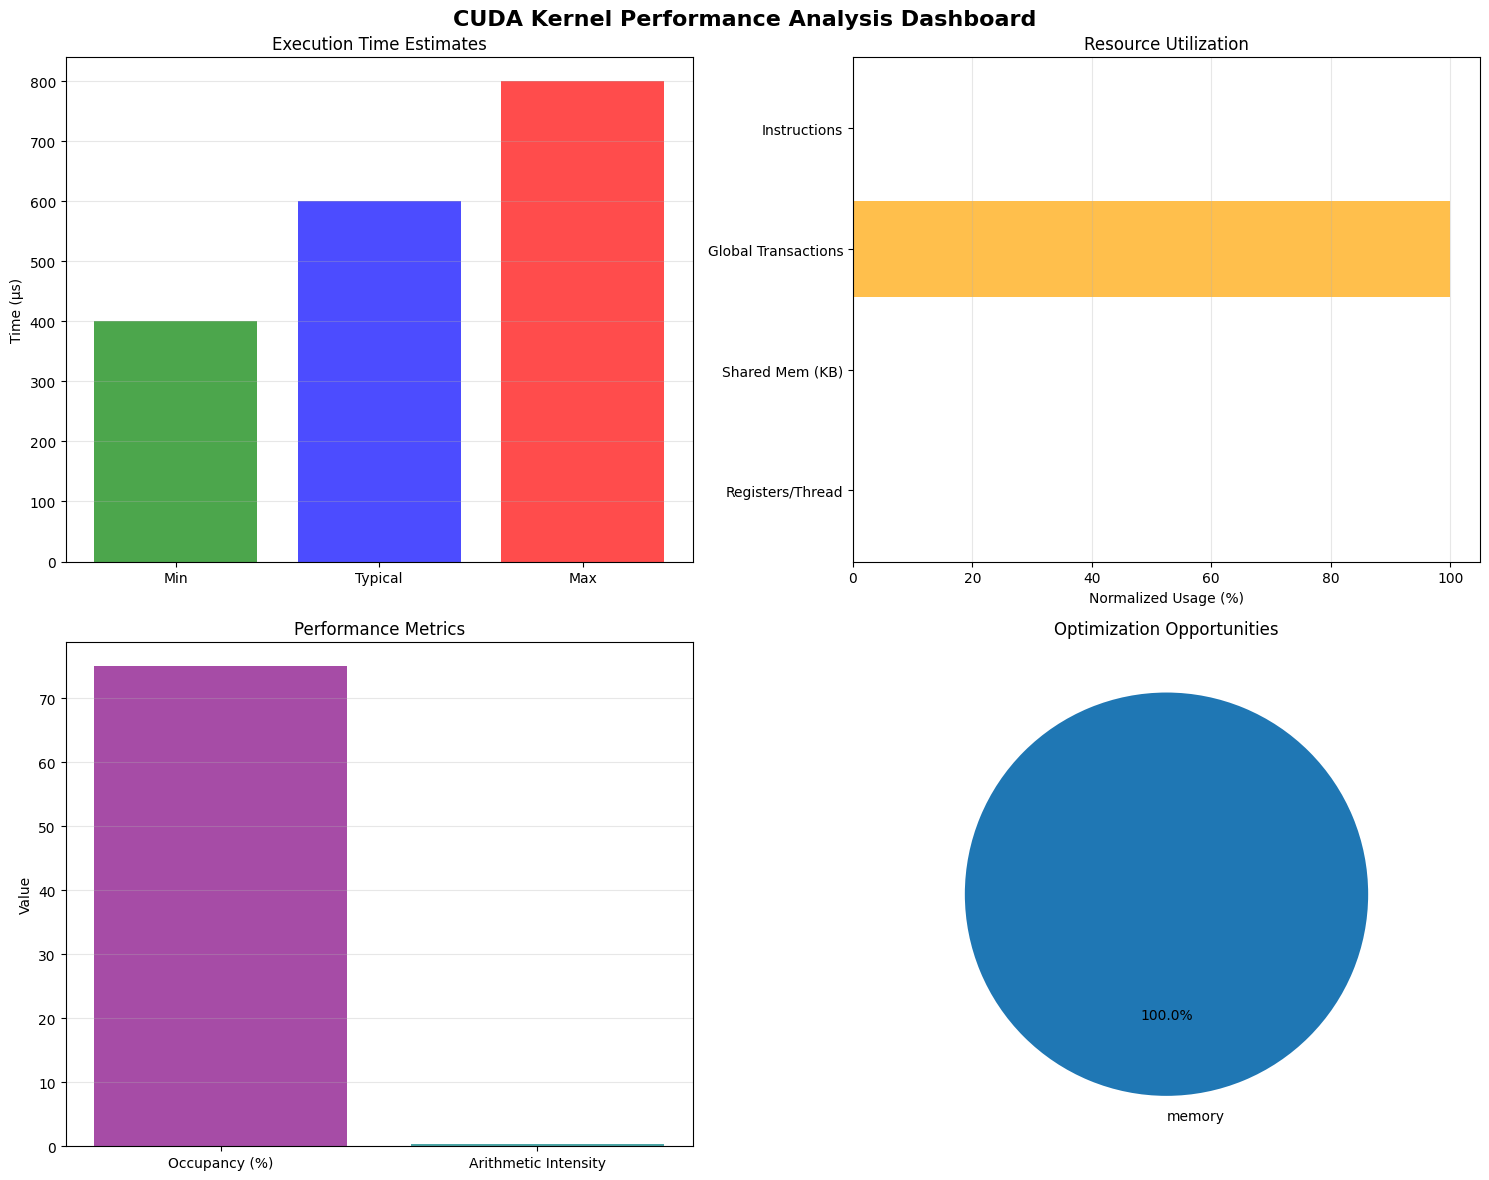

In [26]:
# Example 1: Simple vector addition kernel
vector_add_kernel = """
__global__ void vectorAdd(float *a, float *b, float *c, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) {
        c[idx] = a[idx] + b[idx];
    }
}
"""

# Analyze the vector addition kernel
print("Analyzing Vector Addition Kernel...")
analysis_1 = analyze_kernel_with_gpt4(
    kernel_code=vector_add_kernel,
    gpu_model='RTX_2080_Ti',
    grid_dim=(1024, 1, 1),
    block_dim=(256, 1, 1),
    data_size=1024*256  # 1M elements
)

if 'error' not in analysis_1:
    print_analysis_summary(analysis_1)
    create_performance_dashboard(analysis_1)
else:
    print(f"Error: {analysis_1['error']}")

In [27]:
# Example 2: Matrix multiplication kernel
matmul_kernel = """
__global__ void matrixMul(float *A, float *B, float *C, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < N && col < N) {
        float sum = 0.0f;
        for (int k = 0; k < N; k++) {
            sum += A[row * N + k] * B[k * N + col];
        }
        C[row * N + col] = sum;
    }
}
"""

# Analyze the matrix multiplication kernel
print("Analyzing Matrix Multiplication Kernel...")
analysis_2 = analyze_kernel_with_gpt4(
    kernel_code=matmul_kernel,
    gpu_model='RTX_2080_Ti',
    grid_dim=(32, 32, 1),  # 1024x1024 matrix
    block_dim=(16, 16, 1),
    data_size=1024*1024
)

if 'error' not in analysis_2:
    print_analysis_summary(analysis_2)
    create_performance_dashboard(analysis_2)
else:
    print(f"Error: {analysis_2['error']}")

Analyzing Matrix Multiplication Kernel...
Error: Expecting ',' delimiter: line 20 column 47 (char 864)


## Custom Kernel Analysis

Use this cell to analyze your own kernel code:

In [28]:
import glob
from pathlib import Path

# Batch analyze all kernel files in a directory and save one JSON

def analyze_kernels_in_directory(
    directory_path: str,
    gpu_model: str = 'RTX_2080_Ti',
    grid_dim: Tuple[int, int, int] = (1, 1, 1),
    block_dim: Tuple[int, int, int] = (256, 1, 1),
    data_size: Optional[int] = None,
    model: str = "gpt-4o"
) -> Dict:
    """
    Analyze all kernel source files in the given directory.
    Supported extensions: .cu, .cuh, .ptx, .cl
    Returns a dict with results keyed by relative path.
    """
    directory = Path(directory_path)
    if not directory.exists() or not directory.is_dir():
        return {"error": f"Directory not found: {directory_path}"}

    # Collect files
    exts = ["*.cu", "*.cuh", "*.ptx", "*.cl"]
    files: List[Path] = []
    for pattern in exts:
        files.extend(directory.rglob(pattern))

    if not files:
        return {"error": f"No kernel files found in {directory_path}"}

    print(f"Found {len(files)} kernel files to analyze.")

    results: Dict[str, Dict] = {
        "_batch_metadata": {
            "timestamp": datetime.now().isoformat(),
            "directory": str(directory.resolve()),
            "gpu_model": gpu_model,
            "grid_dim": grid_dim,
            "block_dim": block_dim,
            "data_size": data_size,
            "model": model,
        },
        "analyses": {}
    }

    for file_path in files:
        rel_key = str(file_path.relative_to(directory))
        print(f"\nAnalyzing: {rel_key}")
        try:
            # Read file as text (ignore errors for non-text like .ptx)
            kernel_code = file_path.read_text(errors='ignore')
        except Exception as e:
            results["analyses"][rel_key] = {"error": f"Failed to read file: {e}"}
            continue

        analysis = analyze_kernel_with_gpt4(
            kernel_code=kernel_code,
            gpu_model=gpu_model,
            grid_dim=grid_dim,
            block_dim=block_dim,
            data_size=data_size,
            model=model
        )
        results["analyses"][rel_key] = analysis

    return results

# Configure and run directory batch analysis

kernels_dir, output_dir = get_config_paths()
batch_gpu_model = 'RTX_2080_Ti'
batch_grid_dim = (1, 1, 1)
batch_block_dim = (256, 1, 1)
batch_data_size = None  # optional

print(f"Scanning directory: {kernels_dir}")
all_results = analyze_kernels_in_directory(
    directory_path=str(kernels_dir),
    gpu_model=batch_gpu_model,
    grid_dim=batch_grid_dim,
    block_dim=batch_block_dim,
    data_size=batch_data_size,
    model="gpt-4o"
)

# Save to a single JSON in output_dir
output_dir.mkdir(parents=True, exist_ok=True)
output_name = f"all_kernels_analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
output_path = output_dir / output_name

with open(output_path, 'w') as f:
    json.dump(all_results, f, indent=2)

print(f"\n💾 Batch analysis saved to: {output_path}")

Configuration paths:
  KERNELS_DIR: /content/drive/MyDrive/kernels_src (exists: True)
  OUTPUT_DIR : /content/drive/MyDrive (exists: True)
Scanning directory: /content/drive/MyDrive/kernels_src
Found 399 kernel files to analyze.

Analyzing: validation/10615/14/main.cu

Analyzing: validation/10615/14/img2gray.cu

Analyzing: validation/10615/8/main.cu

Analyzing: validation/10615/8/MatrixMulKernel.cu

Analyzing: validation/10615/9/PictureKernell.cu

Analyzing: validation/10615/9/main.cu

Analyzing: validation/10615/16/img2gray.cu

Analyzing: validation/10615/16/main.cu

Analyzing: validation/10615/6/tonemap_gamma.cu

Analyzing: validation/10615/6/main.cu

Analyzing: validation/11934/94/relu_gpu_backward.cu

Analyzing: validation/11934/94/main.cu

Analyzing: validation/10073/327/softmax_gradient_kernel.cu

Analyzing: validation/10073/327/main.cu

Analyzing: validation/10018/1/Matriz_GPU_Mult.cu

Analyzing: validation/10018/1/main.cu

Analyzing: validation/11647/12/main.cu

Analyzing: vali

## Batch Analysis and Comparison

Analyze multiple kernels and compare their performance:


📊 KERNEL PERFORMANCE COMPARISON
    Kernel  Typical Time (μs) Primary Bottleneck Memory Pattern Occupancy  Arithmetic Intensity  Registers/Thread Shared Memory (KB)
Vector Add                600             memory      coalesced       75%                  0.33                10                N/A


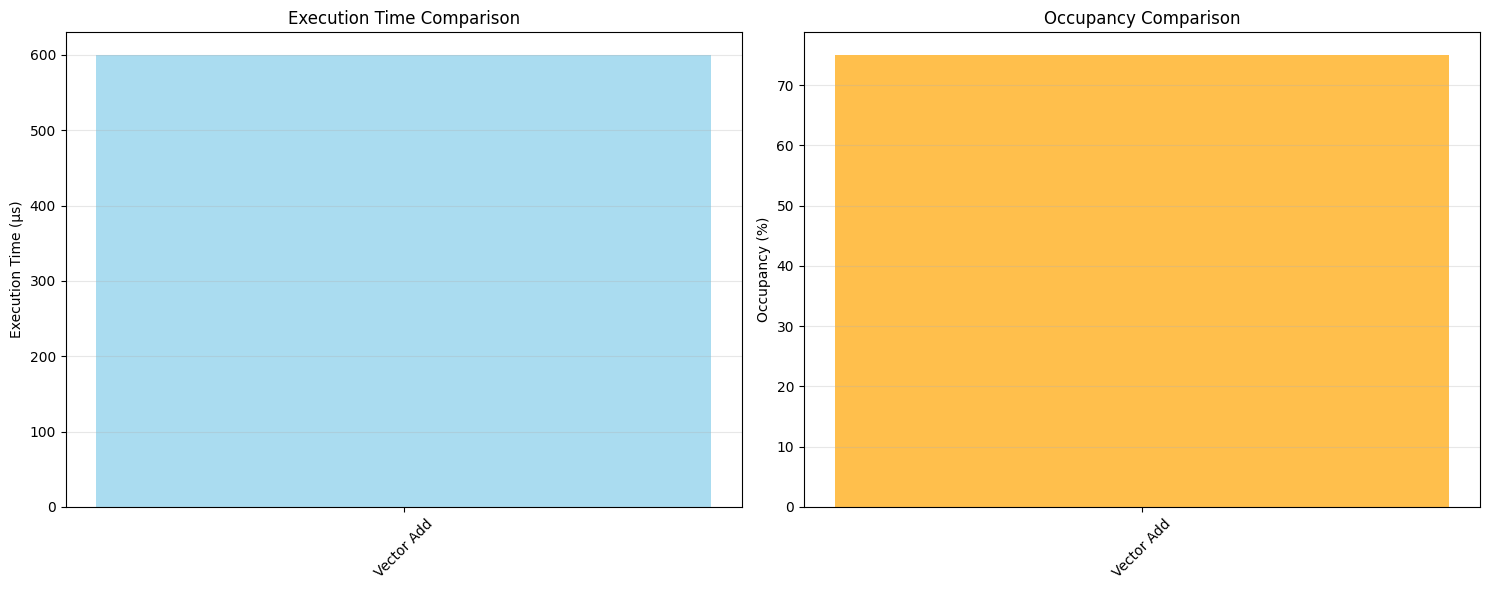

In [29]:
def compare_kernel_analyses(analyses: List[Dict], labels: List[str]):
    """
    Compare multiple kernel analyses side by side.
    """
    if len(analyses) != len(labels):
        print("Error: Number of analyses must match number of labels")
        return

    # Filter out error analyses
    valid_analyses = [(a, l) for a, l in zip(analyses, labels) if 'error' not in a]

    if not valid_analyses:
        print("No valid analyses to compare")
        return

    analyses, labels = zip(*valid_analyses)

    # Create comparison DataFrame
    comparison_data = []
    for analysis, label in zip(analyses, labels):
        timing = analysis.get('execution_time_estimate', {})
        perf = analysis.get('performance_analysis', {})
        resources = analysis.get('resource_utilization', {})

        comparison_data.append({
            'Kernel': label,
            'Typical Time (μs)': timing.get('microseconds_typical', 'N/A'),
            'Primary Bottleneck': perf.get('primary_bottleneck', 'N/A'),
            'Memory Pattern': perf.get('memory_pattern', 'N/A'),
            'Occupancy': perf.get('occupancy_estimate', 'N/A'),
            'Arithmetic Intensity': perf.get('arithmetic_intensity', 'N/A'),
            'Registers/Thread': resources.get('registers_per_thread', 'N/A'),
            'Shared Memory (KB)': resources.get('shared_memory_per_block_bytes', 0) / 1024 if resources.get('shared_memory_per_block_bytes') else 'N/A'
        })

    df = pd.DataFrame(comparison_data)
    print("\n📊 KERNEL PERFORMANCE COMPARISON")
    print("="*100)
    print(df.to_string(index=False))

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Timing comparison
    timing_data = [timing.get('microseconds_typical', 0) for timing in [a.get('execution_time_estimate', {}) for a in analyses]]
    axes[0].bar(labels, timing_data, color='skyblue', alpha=0.7)
    axes[0].set_ylabel('Execution Time (μs)')
    axes[0].set_title('Execution Time Comparison')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', alpha=0.3)

    # Occupancy comparison
    occupancy_data = []
    for analysis in analyses:
        perf = analysis.get('performance_analysis', {})
        occ_str = str(perf.get('occupancy_estimate', '0'))
        occ_match = re.search(r'\d+', occ_str)
        occupancy_data.append(float(occ_match.group()) if occ_match else 0)

    axes[1].bar(labels, occupancy_data, color='orange', alpha=0.7)
    axes[1].set_ylabel('Occupancy (%)')
    axes[1].set_title('Occupancy Comparison')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

# Example: Compare the two kernels we analyzed earlier
if 'analysis_1' in locals() and 'analysis_2' in locals():
    compare_kernel_analyses(
        [analysis_1, analysis_2],
        ['Vector Add', 'Matrix Multiply']
    )
else:
    print("Run the example analyses above first to enable comparison")

## Advanced Features

Additional utilities for specialized analysis:

In [30]:
def analyze_scaling_behavior(kernel_code: str, gpu_model: str,
                           data_sizes: List[int], base_grid_dim: Tuple[int, int, int],
                           base_block_dim: Tuple[int, int, int]):
    """
    Analyze how kernel performance scales with different data sizes.
    """
    results = []

    for data_size in data_sizes:
        # Adjust grid size based on data size
        total_threads = base_grid_dim[0] * base_grid_dim[1] * base_grid_dim[2] * \
                       base_block_dim[0] * base_block_dim[1] * base_block_dim[2]
        scale_factor = data_size / total_threads

        scaled_grid = (int(base_grid_dim[0] * scale_factor**0.5),
                      int(base_grid_dim[1] * scale_factor**0.5),
                      base_grid_dim[2])

        print(f"Analyzing data size: {data_size:,} elements...")
        analysis = analyze_kernel_with_gpt4(
            kernel_code=kernel_code,
            gpu_model=gpu_model,
            grid_dim=scaled_grid,
            block_dim=base_block_dim,
            data_size=data_size
        )

        if 'error' not in analysis:
            timing = analysis.get('execution_time_estimate', {})
            results.append({
                'data_size': data_size,
                'execution_time': timing.get('microseconds_typical', 0),
                'grid_dim': scaled_grid,
                'analysis': analysis
            })
        else:
            print(f"  Error for size {data_size}: {analysis['error']}")

    if results:
        # Plot scaling behavior
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        data_sizes = [r['data_size'] for r in results]
        times = [r['execution_time'] for r in results]

        plt.loglog(data_sizes, times, 'o-', linewidth=2, markersize=8)
        plt.xlabel('Data Size (elements)')
        plt.ylabel('Execution Time (μs)')
        plt.title('Scaling Behavior (Log-Log Plot)')
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        throughput = [ds / (t * 1e-6) for ds, t in zip(data_sizes, times)]  # elements/second
        plt.semilogx(data_sizes, throughput, 's-', linewidth=2, markersize=8, color='orange')
        plt.xlabel('Data Size (elements)')
        plt.ylabel('Throughput (elements/sec)')
        plt.title('Throughput vs Data Size')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Print scaling summary
        print("\n📈 SCALING ANALYSIS SUMMARY:")
        print(f"Data Size Range: {min(data_sizes):,} - {max(data_sizes):,} elements")
        print(f"Time Range: {min(times):.2f} - {max(times):.2f} μs")
        print(f"Peak Throughput: {max(throughput):.2e} elements/sec")

        return results
    else:
        print("No successful analyses to plot")
        return []

def export_analysis_report(analysis: Dict, filename: str = None):
    """
    Export analysis results to a formatted text report.
    """
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"kernel_analysis_report_{timestamp}.txt"

    with open(filename, 'w') as f:
        f.write("CUDA KERNEL PERFORMANCE ANALYSIS REPORT\n")
        f.write("=" * 80 + "\n\n")

        # Metadata
        metadata = analysis.get('_metadata', {})
        f.write(f"Analysis Date: {metadata.get('timestamp', 'Unknown')}\n")
        f.write(f"Target GPU: {metadata.get('gpu_target', 'Unknown')}\n")
        f.write(f"Grid Dimensions: {metadata.get('grid_dim', 'Unknown')}\n")
        f.write(f"Block Dimensions: {metadata.get('block_dim', 'Unknown')}\n")
        f.write(f"Data Size: {metadata.get('data_size', 'Unknown')}\n\n")

        # Execution time
        timing = analysis.get('execution_time_estimate', {})
        f.write("EXECUTION TIME ESTIMATE:\n")
        f.write("-" * 40 + "\n")
        f.write(f"Minimum: {timing.get('microseconds_min', 'N/A')} μs\n")
        f.write(f"Typical: {timing.get('microseconds_typical', 'N/A')} μs\n")
        f.write(f"Maximum: {timing.get('microseconds_max', 'N/A')} μs\n")
        f.write(f"Confidence: {timing.get('confidence_level', 'N/A')}\n\n")

        # Performance analysis
        perf = analysis.get('performance_analysis', {})
        f.write("PERFORMANCE ANALYSIS:\n")
        f.write("-" * 40 + "\n")
        f.write(f"Primary Bottleneck: {perf.get('primary_bottleneck', 'N/A')}\n")
        f.write(f"Memory Pattern: {perf.get('memory_pattern', 'N/A')}\n")
        f.write(f"Branch Divergence Risk: {perf.get('branch_divergence_risk', 'N/A')}\n")
        f.write(f"Occupancy Estimate: {perf.get('occupancy_estimate', 'N/A')}\n")
        f.write(f"Arithmetic Intensity: {perf.get('arithmetic_intensity', 'N/A')} ops/byte\n\n")

        if perf.get('bottleneck_explanation'):
            f.write(f"Bottleneck Explanation:\n{perf['bottleneck_explanation']}\n\n")

        # Resource utilization
        resources = analysis.get('resource_utilization', {})
        f.write("RESOURCE UTILIZATION:\n")
        f.write("-" * 40 + "\n")
        f.write(f"Registers per Thread: {resources.get('registers_per_thread', 'N/A')}\n")
        f.write(f"Shared Memory per Block: {resources.get('shared_memory_per_block_bytes', 'N/A')} bytes\n")
        f.write(f"Global Memory Transactions: {resources.get('global_memory_transactions', 'N/A')}\n")
        f.write(f"Instruction Count Estimate: {resources.get('instruction_count_estimate', 'N/A')}\n\n")

        # Optimization suggestions
        optimizations = analysis.get('optimization_suggestions', [])
        if optimizations:
            f.write("OPTIMIZATION SUGGESTIONS:\n")
            f.write("-" * 40 + "\n")
            for i, opt in enumerate(optimizations, 1):
                f.write(f"{i}. [{opt.get('category', 'general').upper()}] {opt.get('suggestion', 'N/A')}\n")
                f.write(f"   Expected Improvement: {opt.get('expected_improvement', 'N/A')}\n")
                f.write(f"   Difficulty: {opt.get('difficulty', 'N/A')}\n\n")

        # Scaling analysis
        scaling = analysis.get('scaling_analysis', {})
        if scaling:
            f.write("SCALING ANALYSIS:\n")
            f.write("-" * 40 + "\n")
            f.write(f"Data Size Scaling: {scaling.get('scales_with_data_size', 'N/A')}\n")
            f.write(f"Parallel Efficiency: {scaling.get('parallel_efficiency', 'N/A')}\n")
            f.write(f"Weak Scaling: {scaling.get('weak_scaling_behavior', 'N/A')}\n")
            f.write(f"Strong Scaling: {scaling.get('strong_scaling_behavior', 'N/A')}\n\n")

        # Additional notes
        if analysis.get('comparison_notes'):
            f.write("ADDITIONAL NOTES:\n")
            f.write("-" * 40 + "\n")
            f.write(f"{analysis['comparison_notes']}\n\n")

        f.write("=" * 80 + "\n")
        f.write("Report generated by GPU Kernel Time Predictor\n")

    print(f"📄 Analysis report exported to: {filename}")
    return filename

print("Advanced analysis functions defined!")

Advanced analysis functions defined!


## Configuration and Setup Notes

### Environment Setup

1. **OpenAI API Key for Google Colab**:
   - Click the **key icon** (🔑) in the left sidebar of Colab
   - Click **"Add new secret"**
   - Name: `OPENAI_API_KEY`
   - Value: Your OpenAI API key
   - Toggle notebook access to ON
   
   *Alternative for local Jupyter*: Set environment variable `OPENAI_API_KEY=your_api_key_here`

2. **GPU Models**: The notebook includes specifications for common GPUs used in research. You can add more GPU models by extending the `GPU_SPECS` dictionary.

3. **Cost Considerations**: Each analysis call costs approximately $0.01-0.05 depending on kernel complexity and response length.

### Usage Tips

- **Kernel Complexity**: More complex kernels will get more detailed and accurate analysis
- **Launch Configuration**: Providing realistic grid/block dimensions improves accuracy
- **Data Size**: Including expected data sizes helps with memory bandwidth calculations
- **Multiple Analyses**: Use batch analysis for comparing optimization variants

### Limitations

- **Estimates Only**: GPT-4 provides educated estimates, not precise measurements
- **Architecture Specifics**: Analysis quality depends on how well GPT-4 knows your target GPU
- **Dynamic Behavior**: Cannot predict runtime-dependent behavior like dynamic branching
- **Validation Needed**: Always validate predictions with actual profiling (nvprof, nsys, ncu)

This notebook is designed to complement your CUDA microbenchmarking work by providing quick performance insights before implementation and helping identify potential optimizations.